# Enerji İstatistik Notları - EiN66 - WTI Ham Petrol Bireysel Yatırımcısı 
Barış Sanlı [barissanli.com]

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
#!pip install lxml

In [26]:

"""
Jens Olson
jens.olson@gmail.com
"""

import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import requests, io, zipfile, csv, lxml.etree

def get_CFTC_COT_FFOP_current(category):
    """
    Parameters:
        category: 'financial' or 'commodity'
    """
    output = []
    if category == 'financial': 
        feed_url = 'https://www.cftc.gov/dea/newcot/FinFutWk.txt'
        fields_url = 'https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalViewable/cotvariablestfm.html'
    else: 
        feed_url = 'https://www.cftc.gov/dea/newcot/f_disagg.txt'
        fields_url = 'https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalViewable/CFTC_023168.html'
    
    fields_response = requests.get(fields_url)
    doc = lxml.etree.HTML(fields_response.content.decode())
    header = [field.split(' ')[1] for field in doc.xpath("//td/p/text()")]
    response = requests.get(feed_url)
    f = io.StringIO(response.content.decode())
    csv_reader = csv.reader(f)
    for row in csv_reader:
        row_dict = {}
        for index, value in enumerate(row):
            row_dict[header[index]] = value.strip()
        output.append(row_dict)
    df = pd.DataFrame(output)
    
    if category == 'financial':
        df.set_index('Report_Date_as_MM_DD_YYYY', drop=True, inplace=True)
    else:
        df.set_index('As_of_Date_Form_MM/DD/YYYY', drop=True, inplace=True)
        
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    #del df.index.name
    return df

def get_CFTC_COT_FFOP_hist(category):
    """ Compiles CFTC COT reports for 2006-2016 and for 2017 into one pandas
        dataframe
        Paramters:
            category: 'financial' or 'commodity'
    """
    if category == 'financial':    
        try:    
            df = pd.read_pickle('06_17_CFTC_FFOP.pkl')
        except:    
            # see answer here: https://stackoverflow.com/questions/49575183/dtypewarning-columns-15-16-18-24-have-mixed-types-columns-get-removed-if-it
            df0616 = pd.read_csv('F_TFF_2006_2016.txt', dtype={3: str, 82: str}) 

            df17 = pd.read_csv('FinFut17.txt')
            df18 = pd.read_csv('FinFut18.txt')
            df1718 = df17.append(df18, sort=False)
            
            df = df0616.append(df1718, sort=False)
            df.set_index('Report_Date_as_YYYY-MM-DD', drop=True, inplace=True)
            df.index = pd.to_datetime(df.index, infer_datetime_format=True)
            del df.index.name
            df.to_pickle('06_17_CFTC_FFOP.pkl')
        
    else:
        try:    
            df = pd.read_pickle('06_17_CFTC_FFOP_commodity.pkl')
        except:    
            # see answer here: https://stackoverflow.com/questions/49575183/dtypewarning-columns-15-16-18-24-have-mixed-types-columns-get-removed-if-it
            df0616 = pd.read_csv('F_Disagg06_16.txt',
                                 dtype=dict.fromkeys([3, 120, 121, 125, 133, 134, 135, 145,
                                                      146, 147, 148, 149, 150, 151, 152, 153,
                                                      154, 155, 156, 157, 158, 159, 160, 186], str))

            df17 = pd.read_csv('f_17.txt',
                               dtype=dict.fromkeys([133, 145, 146, 147, 148, 149, 159, 160], str))
            
            df18 = pd.read_csv('f_18.txt',
                               dtype=dict.fromkeys([133, 145, 146, 147, 148, 149, 159, 160], str))

            df1718 = df17.append(df18, sort=False)
            
            df = df0616.append(df1718, sort=False)
            df.set_index('Report_Date_as_YYYY-MM-DD', drop=True, inplace=True)
            df.index = pd.to_datetime(df.index, infer_datetime_format=True)
          #   del df.index.name
            df.to_pickle('06_17_CFTC_FFOP_commodity.pkl')
        
    return df

def get_CFTC_COT_FFOP_CY(category):
    """ Downloads zipped CFTC COT report for current year and unzips into pandas dataframe
    """
    if category == 'financial':
        zip_2019_url = 'https://www.cftc.gov/files/dea/history/fut_fin_txt_2025.zip'
    else:
        #zip_2019_url = 'https://www.cftc.gov/files/dea/history/fut_disagg_txt_2019.zip'
        zip_2019_url = 'https://www.cftc.gov/files/dea/history/fut_disagg_txt_2025.zip'
    r = requests.get(zip_2019_url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    
    for zipinfo in z.infolist():
        with z.open(zipinfo) as f:
            if category == 'financial':
                df = pd.read_csv(zipinfo.filename)
            else:
                df = pd.read_csv(zipinfo.filename,
                                 dtype=dict.fromkeys([120, 121, 133, 134, 145, 146,
                                                      147, 148, 134,145, 149, 150,
                                                      154, 156, 157, 159, 160], str))
            
    df.set_index('Report_Date_as_YYYY-MM-DD', drop=True, inplace=True)
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    #del df.index.name
    return df

def get_CFTC_COT_cols(category, contracts):
    """ Concatenates historical and current year pandas dataframes and
        selects relevant futures contracts
    """
    df1 = get_CFTC_COT_FFOP_hist(category)
    df2 = get_CFTC_COT_FFOP_CY(category)
    df3 = get_CFTC_COT_FFOP_current(category)
    df = df1.append(df2, sort=False)
    if max(df3.index) != max(df2.index):
        df = df.append(df3, sort=False)
        
    df = df[df['Market_and_Exchange_Names'].isin(contracts)]
    return df
  
def get_CFTC_COT_LS(category):
    d = {
        'financial': {
            'instruments': {
                '10-YEAR U.S. TREASURY NOTES - CHICAGO BOARD OF TRADE': 'CBOE_US10Y_LS',
                '3-MONTH EURODOLLARS - CHICAGO MERCANTILE EXCHANGE': 'CBOE_GE_LS',
                'BRITISH POUND STERLING - CHICAGO MERCANTILE EXCHANGE': 'CBOE_GBP_LS',
                'E-MINI S&P 500 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE': 'CBOE_ES_LS',
                'EURO FX - CHICAGO MERCANTILE EXCHANGE': 'CBOE_EUR_LS',
                'JAPANESE YEN - CHICAGO MERCANTILE EXCHANGE': 'CBOE_JPY_LS',
                'VIX FUTURES - CBOE FUTURES EXCHANGE': 'CBOE_VIX_LS',    
            },
            'fields': [
                'Lev_Money_Positions_Long_All',
                'Lev_Money_Positions_Short_All', 
            ],
        },
        'commodity': {
            'instruments': {
                'GOLD - COMMODITY EXCHANGE INC.': 'CBOE_GOLD_LS',
                'CRUDE OIL, LIGHT SWEET - NEW YORK MERCANTILE EXCHANGE': 'CBOE_OIL_LS',
            },
            'fields': [
                'M_Money_Positions_Long_All',
                'M_Money_Positions_Short_All',
            ],
        },
    }
            
    contracts = list(d[category]['instruments'].keys())
    fields = list(d[category]['fields'])
    
    df = get_CFTC_COT_cols(category=category, contracts=contracts)
    
    dfs = {}
    for item in fields:
        dfs[item] = df.pivot_table(index=df.index,
                                   columns='Market_and_Exchange_Names',
                                   values=item,
                                   aggfunc='sum').rename_axis(None, axis=1)

        dfs[item] = dfs[item].apply(lambda x: pd.to_numeric(x))
        
    df1 = dfs[d[category]['fields'][0]]-dfs[d[category]['fields'][1]]
    df1.rename(columns=d[category]['instruments'], inplace=True)
    return df1


In [27]:
df=get_CFTC_COT_FFOP_CY("commodity");

In [28]:
df[df['Market_and_Exchange_Names'].str.contains("crude", case=False, na=False)].sort_values("Open_Interest_All",ascending=False)["Market_and_Exchange_Names"].iloc[0]

'CRUDE OIL, LIGHT SWEET-WTI - ICE FUTURES EUROPE'

In [29]:
dfcrude=df[df['Market_and_Exchange_Names']=='CRUDE OIL, LIGHT SWEET-WTI - ICE FUTURES EUROPE']

In [30]:
#dfcrude.columns.str.contains("other",case=False)
#dfcrude.columns.str.contains("All",case=False)

In [31]:
dfcrude.iloc[0,][6:22]

Open_Interest_All                  756331
Prod_Merc_Positions_Long_All       414815
Prod_Merc_Positions_Short_All      369785
Swap_Positions_Long_All             13437
Swap__Positions_Short_All           77132
Swap__Positions_Spread_All          21721
M_Money_Positions_Long_All           7348
M_Money_Positions_Short_All         65209
M_Money_Positions_Spread_All        17384
Other_Rept_Positions_Long_All      108582
Other_Rept_Positions_Short_All      32752
Other_Rept_Positions_Spread_All    160845
Tot_Rept_Positions_Long_All        744132
Tot_Rept_Positions_Short_All       744828
NonRept_Positions_Long_All          12199
NonRept_Positions_Short_All         11503
Name: 2025-05-27 00:00:00, dtype: object

In [32]:
dfcrude.iloc[:,16] #Other_Rept_Positions_Short_All
dfcrude.iloc[:,15] #Other_Rept_Positions_Long_All

Report_Date_as_YYYY-MM-DD
2025-05-27    108582
2025-05-20     97422
2025-05-13    101581
2025-05-06    104769
2025-04-29    109820
2025-04-22    108957
2025-04-15     98026
2025-04-08     99951
2025-04-01     95360
2025-03-25     74895
2025-03-18     80793
2025-03-11     71701
2025-03-04     73186
2025-02-25     56832
2025-02-18     55018
2025-02-11     56332
2025-02-04     54214
2025-01-28     54701
2025-01-21     70659
2025-01-14     63423
2025-01-07     94501
Name: Other_Rept_Positions_Long_All, dtype: int64

In [33]:
for i in range(22):
    print(i," ",dfcrude.columns[i])

0   Market_and_Exchange_Names
1   As_of_Date_In_Form_YYMMDD
2   CFTC_Contract_Market_Code
3   CFTC_Market_Code
4   CFTC_Region_Code
5   CFTC_Commodity_Code
6   Open_Interest_All
7   Prod_Merc_Positions_Long_All
8   Prod_Merc_Positions_Short_All
9   Swap_Positions_Long_All
10   Swap__Positions_Short_All
11   Swap__Positions_Spread_All
12   M_Money_Positions_Long_All
13   M_Money_Positions_Short_All
14   M_Money_Positions_Spread_All
15   Other_Rept_Positions_Long_All
16   Other_Rept_Positions_Short_All
17   Other_Rept_Positions_Spread_All
18   Tot_Rept_Positions_Long_All
19   Tot_Rept_Positions_Short_All
20   NonRept_Positions_Long_All
21   NonRept_Positions_Short_All


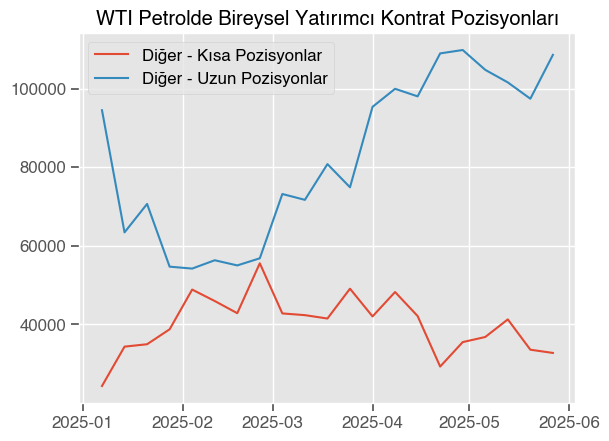

In [34]:
plt.style.use("ggplot")
plt.plot(dfcrude.iloc[:,16], label="Diğer - Kısa Pozisyonlar")
plt.plot(dfcrude.iloc[:,15], label="Diğer - Uzun Pozisyonlar")
plt.title("WTI Petrolde Bireysel Yatırımcı Kontrat Pozisyonları")
plt.legend()

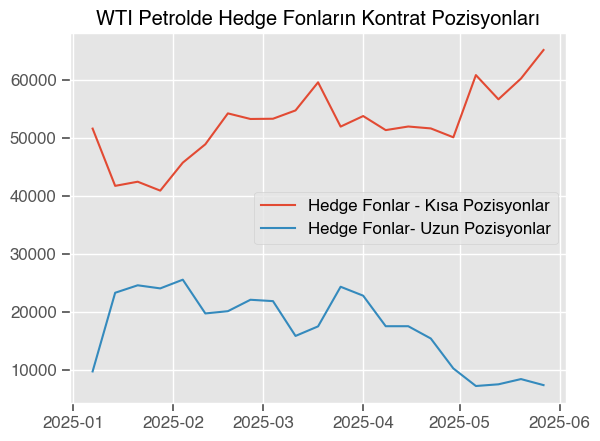

In [35]:
plt.plot(dfcrude.iloc[:,13], label="Hedge Fonlar - Kısa Pozisyonlar")
plt.plot(dfcrude.iloc[:,12], label="Hedge Fonlar- Uzun Pozisyonlar")
plt.title("WTI Petrolde Hedge Fonların Kontrat Pozisyonları")
plt.legend()

In [36]:
import yfinance as yf
import pandas as pd
from datetime import timedelta

# Fetch daily crude oil price data
ticker = "CL=F"
crude_oil = yf.Ticker(ticker)
start_date = "2024-12-01"  # Buffer for first Tuesday
end_date = "2025-06-10"    # Extend past June 3, 2025
data = crude_oil.history(start=start_date, end=end_date, interval="1d")

# Filter for Tuesdays
data.index = pd.to_datetime(data.index)
data["Weekday"] = data.index.weekday
tuesday_data = data[data["Weekday"] == 1]  # 1 = Tuesday
weekly_prices = tuesday_data[["Close"]]

# Make index timezone-naive
weekly_prices.index = weekly_prices.index.tz_localize(None)

# Filter for dates starting from 2025-01-07
weekly_prices = weekly_prices[weekly_prices.index >= "2025-01-07"]

# Handle missing data (optional)
#weekly_prices["Close"] = weekly_prices["Close"].fillna(method="ffill")

# Display result
print(weekly_prices)

# Save to CSV
#weekly_prices.to_csv("weekly_crude_oil_prices.csv")

                Close
Date                 
2025-01-07  74.250000
2025-01-14  77.500000
2025-01-21  75.889999
2025-01-28  73.769997
2025-02-04  72.699997
2025-02-11  73.320000
2025-02-18  71.849998
2025-02-25  68.930000
2025-03-04  68.260002
2025-03-11  66.250000
2025-03-18  66.900002
2025-03-25  69.000000
2025-04-01  71.199997
2025-04-08  59.580002
2025-04-15  61.330002
2025-04-22  64.309998
2025-04-29  60.419998
2025-05-06  59.090000
2025-05-13  63.669998
2025-05-20  62.560001
2025-05-27  60.889999


In [37]:
#plt.plot(combined_data.Close, label="Petrol Fiyat Kapanışı")
#plt.plot(combined_data.Short_Positions, label="Hedge Fonlar - Kısa Pozisyonlar")
#plt.plot(combined_data.Long_Positions, label="Hedge Fonlar- Uzun Pozisyonlar")
#plt.legend()

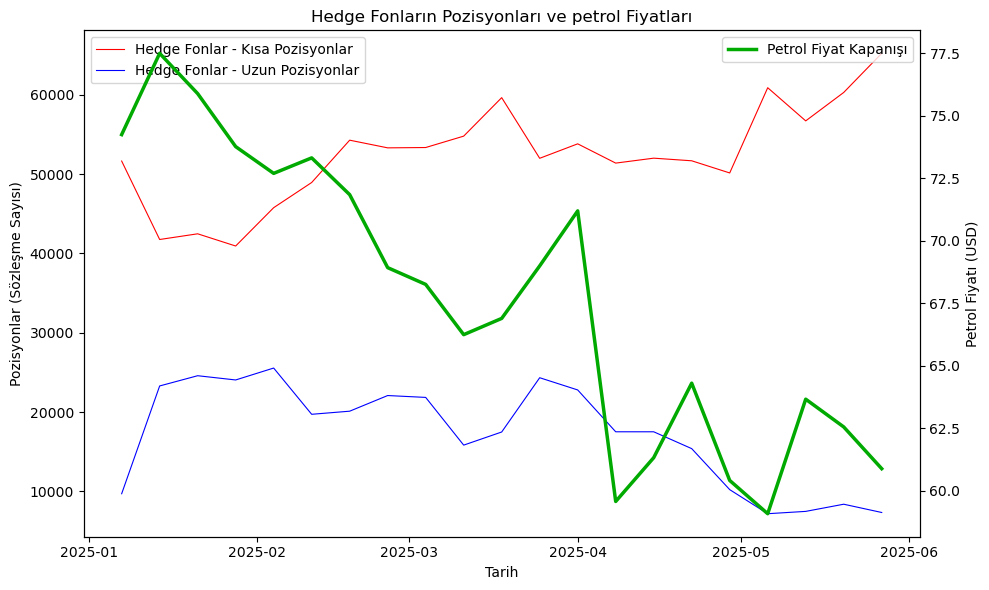

In [38]:
import pandas as pd

# Assuming dfcrude.iloc[:,12] is long positions and dfcrude.iloc[:,13] is short positions
# Extract series with their indices
short_positions = dfcrude.iloc[:,13].rename("Short_Positions")
long_positions = dfcrude.iloc[:,12].rename("Long_Positions")

# Create a DataFrame with short and long positions
cot_data = pd.DataFrame({
    "Short_Positions": short_positions,
    "Long_Positions": long_positions
})

# Sort cot_data index to ascending order to match weekly_prices
cot_data = cot_data.sort_index(ascending=True)

# Ensure indices are timezone-naive and datetime
cot_data.index = pd.to_datetime(cot_data.index).tz_localize(None)
weekly_prices.index = pd.to_datetime(weekly_prices.index).tz_localize(None)

# Combine with weekly_prices
combined_data = cot_data.join(weekly_prices[["Close"]], how="outer")

# Handle missing data (optional: forward-fill)
# Handle missing data using ffill()
combined_data["Close"] = combined_data["Close"].ffill()
combined_data["Short_Positions"] = combined_data["Short_Positions"].ffill()
combined_data["Long_Positions"] = combined_data["Long_Positions"].ffill()

# Display the result
#print(combined_data)

# Save to CSV (optional)
#combined_data.to_csv("combined_cot_oil_data.csv")

plt.style.use('default')  # Plain background, no grid

# Create the plot with a primary and secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Short_Positions and Long_Positions on the primary y-axis (left)
ax1.plot(combined_data.index, combined_data.Short_Positions, label="Hedge Fonlar - Kısa Pozisyonlar", color="red",linewidth=0.8)
ax1.plot(combined_data.index, combined_data.Long_Positions, label="Hedge Fonlar - Uzun Pozisyonlar", color="blue",linewidth=0.8)
ax1.set_xlabel("Tarih")
ax1.set_ylabel("Pozisyonlar (Sözleşme Sayısı)")
ax1.legend(loc="upper left")

# Create a secondary y-axis for Close (oil prices)
ax2 = ax1.twinx()
ax2.plot(combined_data.index, combined_data.Close, label="Petrol Fiyat Kapanışı", color="#00AA00", linewidth=2.5)
ax2.set_ylabel("Petrol Fiyatı (USD)")
ax2.legend(loc="upper right")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.title("Hedge Fonların Pozisyonları ve petrol Fiyatları")
#plt.grid()
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

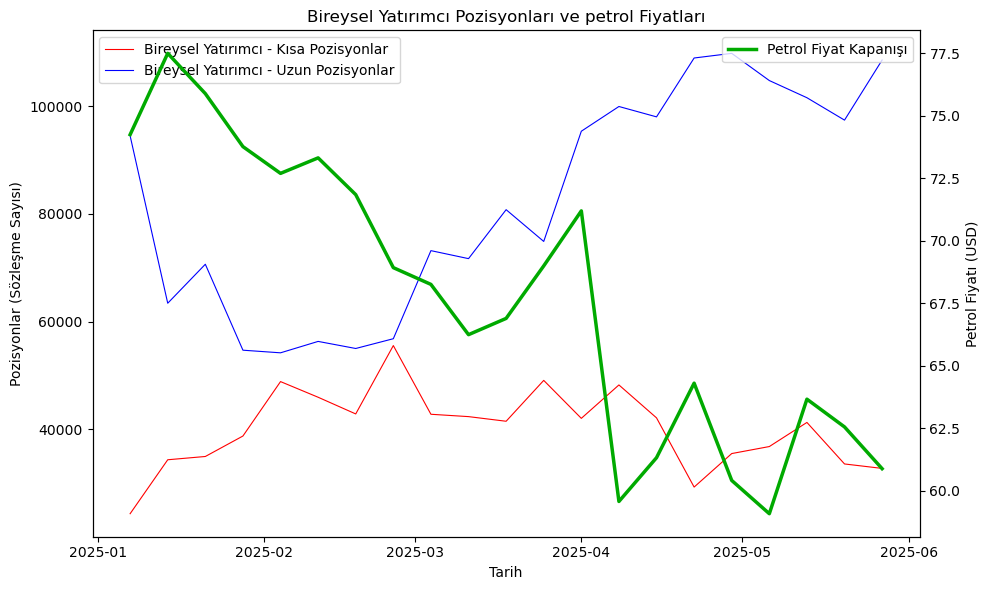

In [39]:
import pandas as pd

# Assuming dfcrude.iloc[:,12] is long positions and dfcrude.iloc[:,13] is short positions
# Extract series with their indices
short_positions = dfcrude.iloc[:,16].rename("Short_Positions")
long_positions = dfcrude.iloc[:,15].rename("Long_Positions")

# Create a DataFrame with short and long positions
cot_data = pd.DataFrame({
    "Short_Positions": short_positions,
    "Long_Positions": long_positions
})

# Sort cot_data index to ascending order to match weekly_prices
cot_data = cot_data.sort_index(ascending=True)

# Ensure indices are timezone-naive and datetime
cot_data.index = pd.to_datetime(cot_data.index).tz_localize(None)
weekly_prices.index = pd.to_datetime(weekly_prices.index).tz_localize(None)

# Combine with weekly_prices
combined_data = cot_data.join(weekly_prices[["Close"]], how="outer")

# Handle missing data (optional: forward-fill)
# Handle missing data using ffill()
combined_data["Close"] = combined_data["Close"].ffill()
combined_data["Short_Positions"] = combined_data["Short_Positions"].ffill()
combined_data["Long_Positions"] = combined_data["Long_Positions"].ffill()

# Display the result
#print(combined_data)

# Save to CSV (optional)
#combined_data.to_csv("combined_cot_oil_data.csv")

plt.style.use('default')  # Plain background, no grid

# Create the plot with a primary and secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Short_Positions and Long_Positions on the primary y-axis (left)
ax1.plot(combined_data.index, combined_data.Short_Positions, label="Bireysel Yatırımcı - Kısa Pozisyonlar", color="red",linewidth=0.8)
ax1.plot(combined_data.index, combined_data.Long_Positions, label="Bireysel Yatırımcı - Uzun Pozisyonlar", color="blue",linewidth=0.8)
ax1.set_xlabel("Tarih")
ax1.set_ylabel("Pozisyonlar (Sözleşme Sayısı)")
ax1.legend(loc="upper left")

# Create a secondary y-axis for Close (oil prices)
ax2 = ax1.twinx()
ax2.plot(combined_data.index, combined_data.Close, label="Petrol Fiyat Kapanışı", color="#00AA00", linewidth=2.5)
ax2.set_ylabel("Petrol Fiyatı (USD)")
ax2.legend(loc="upper right")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.title("Bireysel Yatırımcı Pozisyonları ve petrol Fiyatları")
#plt.grid()
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Pearson Correlation Matrix:
                 Short_Positions  Long_Positions     Close
Short_Positions         1.000000       -0.503508  0.013248
Long_Positions         -0.503508        1.000000 -0.760060
Close                   0.013248       -0.760060  1.000000

Spearman Correlation Matrix:
                 Short_Positions  Long_Positions     Close
Short_Positions         1.000000       -0.490909  0.040260
Long_Positions         -0.490909        1.000000 -0.781818
Close                   0.040260       -0.781818  1.000000

Kendall Correlation Matrix (Custom):
                    Close  Short_Positions  Long_Positions
Close            1.000000         0.038095       -0.571429
Short_Positions  0.038095         1.000000       -0.352381
Long_Positions  -0.571429        -0.352381        1.000000


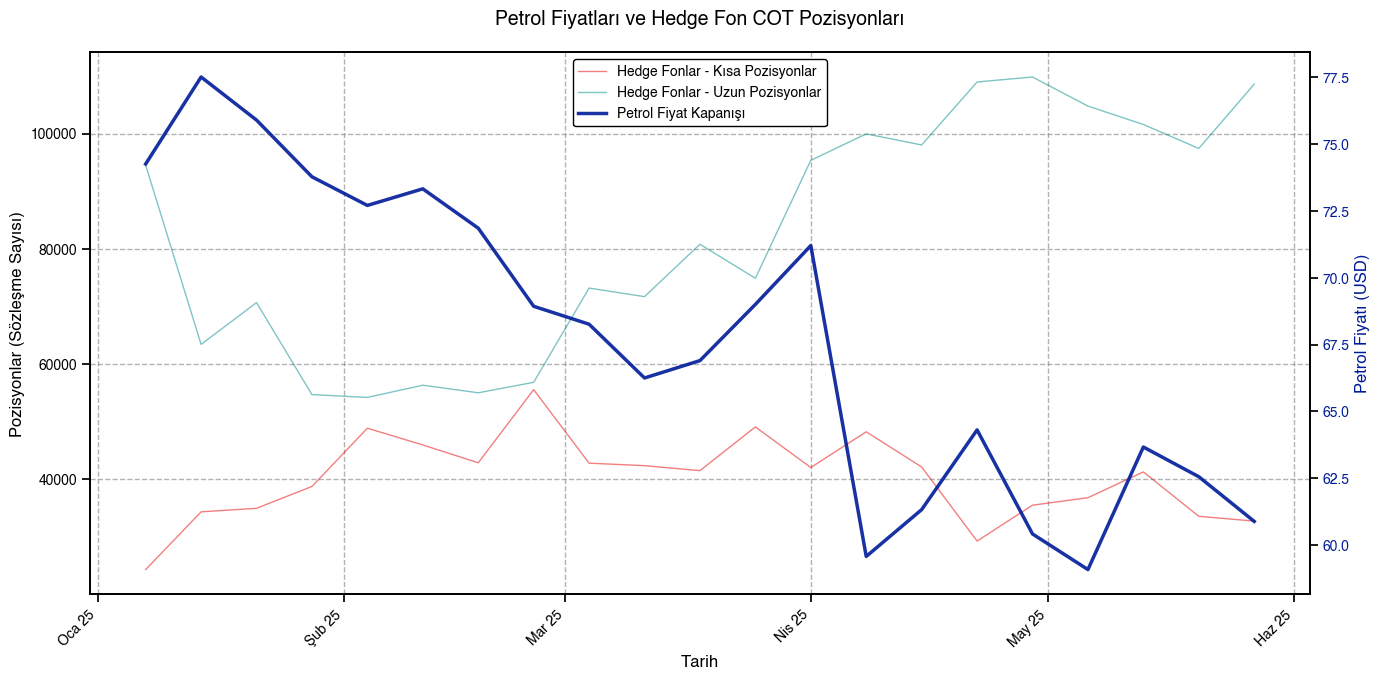

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import MonthLocator
from itertools import combinations

# Handle missing data
combined_data["Close"] = combined_data["Close"].ffill()
combined_data["Short_Positions"] = combined_data["Short_Positions"].ffill()
combined_data["Long_Positions"] = combined_data["Long_Positions"].ffill()

# Calculate correlation coefficients
correlation_matrix = combined_data.corr()
print("Pearson Correlation Matrix:")
print(correlation_matrix)

spearman_corr = combined_data.corr(method="spearman")
print("\nSpearman Correlation Matrix:")
print(spearman_corr)

# Custom Kendall's tau function (to avoid libgfortran issue)
def kendall_tau(x, y):
    n = len(x)
    if n < 2:
        return 0.0
    concordant = 0
    discordant = 0
    for i, j in combinations(range(n), 2):
        if (x[i] - x[j]) * (y[i] - y[j]) > 0:
            concordant += 1
        elif (x[i] - x[j]) * (y[i] - y[j]) < 0:
            discordant += 1
    return (concordant - discordant) / (0.5 * n * (n - 1))

# Calculate Kendall correlation matrix
columns = ["Close", "Short_Positions", "Long_Positions"]
kendall_matrix = pd.DataFrame(index=columns, columns=columns)
for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            kendall_matrix.loc[col1, col2] = 1.0
        else:
            tau = kendall_tau(combined_data[col1].values, combined_data[col2].values)
            kendall_matrix.loc[col1, col2] = tau
print("\nKendall Correlation Matrix (Custom):")
print(kendall_matrix.astype(float))

# Set professional style
#plt.style.use('seaborn-v0_8')
plt.style.use('default')  # Plain background, no grid

sns.set_context("notebook", font_scale=1.1)
plt.rcParams['font.family'] = 'Helvetica'  # Professional font (or Arial)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(14, 7), facecolor='white')

# Define vibrant, professional colors
colors = {
    'Close': '#001B99',  # Bright blue
    'Short_Positions': '#E50000',  # Deep orange
    'Long_Positions': '#008B8B'  # Rich teal
}

# Plot Short and Long Positions on primary y-axis
ax1.plot(combined_data.index, combined_data.Short_Positions, 
         label="Hedge Fonlar - Kısa Pozisyonlar", color=colors['Short_Positions'], 
         linewidth=1, linestyle='-', alpha=0.5)
ax1.plot(combined_data.index, combined_data.Long_Positions, 
         label="Hedge Fonlar - Uzun Pozisyonlar", color=colors['Long_Positions'], 
         linewidth=1, linestyle='-', alpha=0.5)
ax1.set_xlabel("Tarih", fontsize=12, weight='bold')
ax1.set_ylabel("Pozisyonlar (Sözleşme Sayısı)", fontsize=12, weight='bold', color='black')
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)

# Create secondary y-axis for Close
ax2 = ax1.twinx()
ax2.plot(combined_data.index, combined_data.Close, 
         label="Petrol Fiyat Kapanışı", color=colors['Close'], 
         linewidth=2.5, linestyle='-', alpha=0.9)
ax2.set_ylabel("Petrol Fiyatı (USD)", fontsize=12, weight='bold', color=colors['Close'])
ax2.tick_params(axis='y', labelcolor=colors['Close'], labelsize=10)

# Custom Turkish month formatter
turkish_months = {
    1: "Oca", 2: "Şub", 3: "Mar", 4: "Nis", 5: "May", 6: "Haz",
    7: "Tem", 8: "Ağu", 9: "Eyl", 10: "Eki", 11: "Kas", 12: "Ara"
}

# Set monthly ticks and Turkish labels
ax1.xaxis.set_major_locator(MonthLocator())  # One tick per month
tick_locations = ax1.get_xticks()  # Get tick positions
tick_dates = pd.to_datetime(ax1.get_xticks(), unit='D', origin='1970-01-01')  # Convert to datetime
tick_labels = [f"{turkish_months[date.month]} {date.strftime('%y')}" for date in tick_dates]
ax1.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=10)

# Add title
plt.title("Petrol Fiyatları ve Hedge Fon COT Pozisyonları", fontsize=14, weight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center", fontsize=10, 
           frameon=True, facecolor='white', edgecolor='black', framealpha=1.0)

# Add gridlines
ax1.grid(True, linestyle='--', alpha=0.6, color='gray')

# Adjust layout
plt.tight_layout()

# Save as high-quality image
plt.savefig("crude_oil_cot_analysis.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [41]:
weekly_prices.index

DatetimeIndex(['2025-01-07', '2025-01-14', '2025-01-21', '2025-01-28',
               '2025-02-04', '2025-02-11', '2025-02-18', '2025-02-25',
               '2025-03-04', '2025-03-11', '2025-03-18', '2025-03-25',
               '2025-04-01', '2025-04-08', '2025-04-15', '2025-04-22',
               '2025-04-29', '2025-05-06', '2025-05-13', '2025-05-20',
               '2025-05-27'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [42]:
dfcrude.iloc[:,13].index

DatetimeIndex(['2025-05-27', '2025-05-20', '2025-05-13', '2025-05-06',
               '2025-04-29', '2025-04-22', '2025-04-15', '2025-04-08',
               '2025-04-01', '2025-03-25', '2025-03-18', '2025-03-11',
               '2025-03-04', '2025-02-25', '2025-02-18', '2025-02-11',
               '2025-02-04', '2025-01-28', '2025-01-21', '2025-01-14',
               '2025-01-07'],
              dtype='datetime64[ns]', name='Report_Date_as_YYYY-MM-DD', freq=None)

In [43]:
dfcrude.columns.values

array(['Market_and_Exchange_Names', 'As_of_Date_In_Form_YYMMDD',
       'CFTC_Contract_Market_Code', 'CFTC_Market_Code',
       'CFTC_Region_Code', 'CFTC_Commodity_Code', 'Open_Interest_All',
       'Prod_Merc_Positions_Long_All', 'Prod_Merc_Positions_Short_All',
       'Swap_Positions_Long_All', 'Swap__Positions_Short_All',
       'Swap__Positions_Spread_All', 'M_Money_Positions_Long_All',
       'M_Money_Positions_Short_All', 'M_Money_Positions_Spread_All',
       'Other_Rept_Positions_Long_All', 'Other_Rept_Positions_Short_All',
       'Other_Rept_Positions_Spread_All', 'Tot_Rept_Positions_Long_All',
       'Tot_Rept_Positions_Short_All', 'NonRept_Positions_Long_All',
       'NonRept_Positions_Short_All', 'Open_Interest_Old',
       'Prod_Merc_Positions_Long_Old', 'Prod_Merc_Positions_Short_Old',
       'Swap_Positions_Long_Old', 'Swap__Positions_Short_Old',
       'Swap__Positions_Spread_Old', 'M_Money_Positions_Long_Old',
       'M_Money_Positions_Short_Old', 'M_Money_Positions_Sp